In [41]:
import json
import os
from io import BytesIO

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import oci
from PIL import Image
import re

In [42]:
config = oci.config.from_file()

In [43]:
# Initialize service client with default config file
ai_document_client = oci.ai_document.AIServiceDocumentClient(config)

In [47]:
#Object storage Namespace
object_storage_client = oci.object_storage.ObjectStorageClient(config)
NAMESPACE = object_storage_client.get_namespace().data

#Name of Bucket for this demo
BUCKET_NAME = 'bucket-pruebas'

PREFIX = "notebook"

FILENAME = "boleta1.png"

DATASET_PATH = "sample_documents"

In [48]:
response = object_storage_client.put_object(NAMESPACE, BUCKET_NAME, FILENAME, open(os.path.join(DATASET_PATH, FILENAME), "rb"))
response.status

200

In [49]:
response = object_storage_client.get_object(NAMESPACE, BUCKET_NAME, FILENAME)
response.status

200

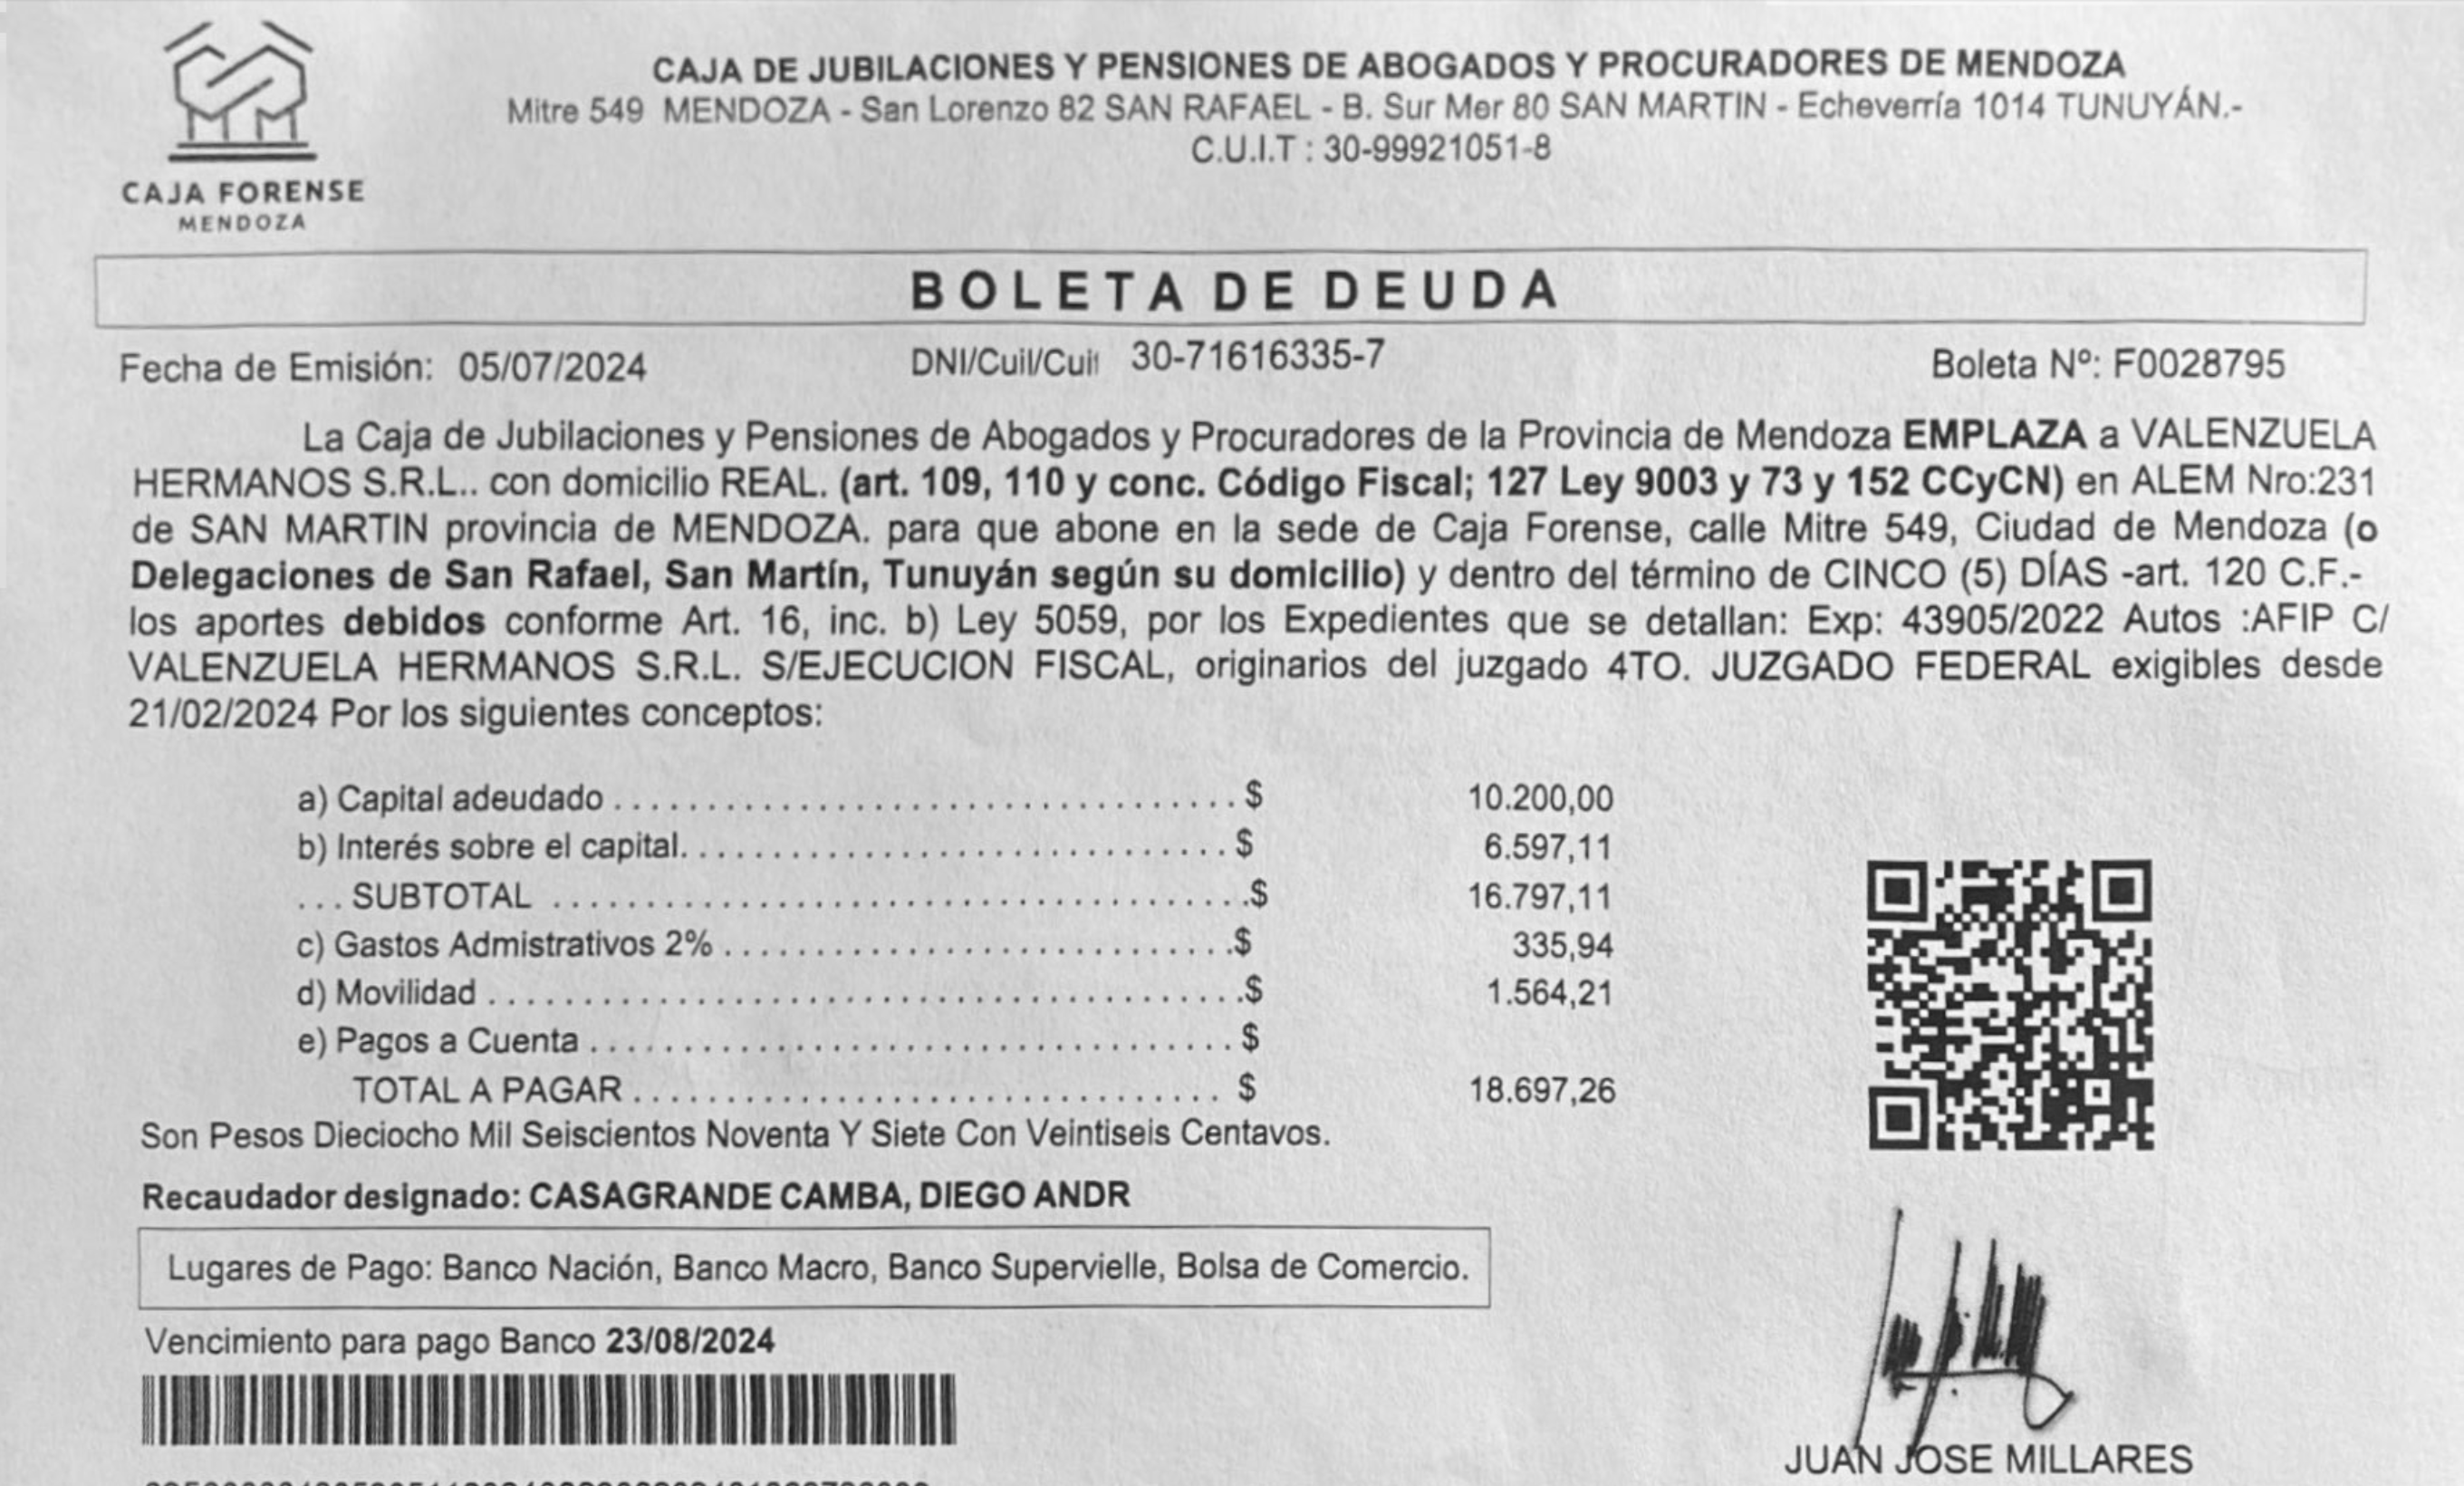

In [50]:
image = Image.open(BytesIO(response.data.content))
image

In [51]:
image.width

2720

In [52]:
# Initialize service client with default config file
ai_document_client = oci.ai_document.AIServiceDocumentClient(config)

In [53]:
# Send the request to service, some parameters are not required, see API
# doc for more info
create_processor_job_response = ai_document_client.create_processor_job(
    create_processor_job_details=oci.ai_document.models.CreateProcessorJobDetails(
        input_location=oci.ai_document.models.ObjectStorageLocations(
            source_type="OBJECT_STORAGE_LOCATIONS",
            object_locations=[
                oci.ai_document.models.ObjectLocation(
                    namespace_name=NAMESPACE,
                    bucket_name=BUCKET_NAME,
                    object_name=FILENAME)]),
        output_location=oci.ai_document.models.OutputLocation(
            namespace_name=NAMESPACE,
            bucket_name=BUCKET_NAME,
            prefix=PREFIX),
        compartment_id=config["compartment_id"],
        processor_config=oci.ai_document.models.GeneralProcessorConfig(
            processor_type="GENERAL",
            features=[
                oci.ai_document.models.DocumentTextExtractionFeature(
                    feature_type="TEXT_EXTRACTION",
                    generate_searchable_pdf=True)],
            document_type="OTHERS",
            is_zip_output_enabled=True,
            language="es"),
        display_name="EXAMPLE-displayName-Value"),
    opc_retry_token="EXAMPLE-opcRetryToken-Value",
    opc_request_id="MOZIJVR14UCLBIBEOUH8<unique_ID>")


In [54]:
output_location = "{}_{}".format(create_processor_job_response.data.output_location.namespace_name, create_processor_job_response.data.output_location.bucket_name)

In [55]:
results_path = os.path.join(PREFIX, create_processor_job_response.data.id, output_location, "results", FILENAME+".json")

In [56]:
response = object_storage_client.get_object(NAMESPACE, BUCKET_NAME, results_path)
response.status

200

In [57]:
bytes_json = response.data.content
json_data = json.loads(bytes_json)
json_data

{'documentMetadata': {'pageCount': 1, 'mimeType': 'image/png'},
 'pages': [{'pageNumber': 1,
   'dimensions': {'width': 2720.0, 'height': 1640.0, 'unit': 'PIXEL'},
   'detectedDocumentTypes': None,
   'detectedLanguages': None,
   'words': [{'text': 'CAJA',
     'confidence': 0.9977383,
     'boundingPolygon': {'normalizedVertices': [{'x': 0.2636029411764706,
        'y': 0.031097560975609756},
       {'x': 0.3011029411764706, 'y': 0.030907128496867855},
       {'x': 0.3011029411764706, 'y': 0.057126640691989805},
       {'x': 0.2636029411764706, 'y': 0.05731707317073171}]}},
    {'text': 'DE',
     'confidence': 0.9977383,
     'boundingPolygon': {'normalizedVertices': [{'x': 0.3011029411764706,
        'y': 0.030907128496867855},
       {'x': 0.325, 'y': 0.03078577460312262},
       {'x': 0.325, 'y': 0.05700528679824457},
       {'x': 0.3011029411764706, 'y': 0.057126640691989805}]}},
    {'text': 'JUBILACIONES',
     'confidence': 0.9977383,
     'boundingPolygon': {'normalizedVerti

In [58]:
words = json_data["pages"][0]["words"]
text_in_words = " ".join([word["text"] for word in words])
text_in_words

'CAJA DE JUBILACIONES Y PENSIONES DE ABOGADOS Y PROCURADORES DE MENDOZA Mitre 549 MENDOZA - San Lorenzo 82 SAN RAFAEL - B. Sur Mer 80 SAN MARTIN - Echeverría 1014 TUNUYN.- C.U.I.T : 30-99921051-8 CAJA FORENSE MENDOZA BOLETADE DEUDA Fecha de Emisión: 05/07/2024 DNI/Cuil/Cuit 30-71616335-7 Boleta N: F0028795 La Caja de Jubilaciones y Pensiones de Abogados y Procuradores de la Provincia de Mendoza EMPLAZA a VALENZUELA HERMANOS S.R.L.. con domicilio REAL. (art. 109, 110 y conc. Código Fiscal; 127 Ley 9003 y 73 y 152 CCyCN) en ALEM Nro:231 de SAN MARTIN provincia de MENDOZA. para que abone en la sede de Caja Forense, calle Mitre 549, Ciudad de Mendoza (o Delegaciones de San Rafael, San Martín, Tunuyán según su domicilio) y dentro del término de CINCO (5) DAS -art. 120 C.F.- los aportes debidos conforme Art. 16, inc. b) Ley 5059, por los Expedientes que se detallan: Exp: 43905/2022 Autos :AFIP C/ VALENZUELA HERMANOS S.R.L. S/EJECUCION FISCAL, originarios del juzgado 4TO. JUZGADO FEDERAL exig

In [59]:
ai_language_client = oci.ai_language.AIServiceLanguageClient(config)

In [60]:
language = ai_language_client.detect_dominant_language(oci.ai_language.models.DetectDominantLanguageDetails(text=text_in_words)).data
language

{
  "languages": [
    {
      "code": "es",
      "name": "Spanish",
      "score": 1.0
    }
  ]
}

In [61]:
key_phrases = ai_language_client.detect_language_key_phrases(oci.ai_language.models.DetectLanguageKeyPhrasesDetails(text=text_in_words,)).data
key_phrases

{
  "key_phrases": [
    {
      "score": 0.9999994197569447,
      "text": "caja"
    },
    {
      "score": 0.9999994197569447,
      "text": "domicilio"
    },
    {
      "score": 0.9999994197569447,
      "text": "mendoza"
    },
    {
      "score": 0.9998106383818767,
      "text": "jubilaciones y pensiones"
    },
    {
      "score": 0.9998106383818767,
      "text": "abogados y procuradores"
    },
    {
      "score": 0.9998106383818767,
      "text": "mendoza mitre 549 mendoza"
    },
    {
      "score": 0.9998106383818767,
      "text": "echeverría 1014 tunuyn.- c.u.i.t"
    },
    {
      "score": 0.9998106383818767,
      "text": "mendoza emplaza"
    },
    {
      "score": 0.9998106383818767,
      "text": "valenzuela hermanos s.r.l"
    },
    {
      "score": 0.9998106383818767,
      "text": "código fiscal"
    },
    {
      "score": 0.9998106383818767,
      "text": "127 ley 9003"
    },
    {
      "score": 0.9998106383818767,
      "text": "152 ccycn"
    },
 

In [62]:
entities = ai_language_client.detect_language_entities(oci.ai_language.models.DetectLanguageEntitiesDetails(text=text_in_words,)).data.entities
entities

[{
   "is_pii": false,
   "length": 70,
   "offset": 0,
   "score": 0.9663315307010304,
   "text": "CAJA DE JUBILACIONES Y PENSIONES DE ABOGADOS Y PROCURADORES DE MENDOZA",
   "type": "ORGANIZATION"
 },
 {
   "is_pii": false,
   "length": 5,
   "offset": 71,
   "score": 0.6970009207725525,
   "text": "Mitre",
   "type": "ORGANIZATION"
 },
 {
   "is_pii": false,
   "length": 3,
   "offset": 77,
   "score": 0.9682633876800537,
   "text": "549",
   "type": "QUANTITY"
 },
 {
   "is_pii": false,
   "length": 21,
   "offset": 81,
   "score": 0.8434774428606033,
   "text": "MENDOZA - San Lorenzo",
   "type": "LOCATION"
 },
 {
   "is_pii": false,
   "length": 2,
   "offset": 103,
   "score": 0.9764769673347473,
   "text": "82",
   "type": "QUANTITY"
 },
 {
   "is_pii": true,
   "length": 10,
   "offset": 106,
   "score": 0.6974806487560272,
   "text": "SAN RAFAEL",
   "type": "PERSON"
 },
 {
   "is_pii": false,
   "length": 10,
   "offset": 119,
   "score": 0.8564413785934448,
   "text": "B. S

In [63]:
pii = ai_language_client.batch_detect_language_pii_entities(oci.ai_language.models.BatchDetectLanguagePiiEntitiesDetails(
    documents=[
        oci.ai_language.models.TextDocument(
            key="1",
            text=text_in_words
        )
    ]
    
)).data
pii

{
  "documents": [
    {
      "entities": [
        {
          "id": "1",
          "length": 13,
          "offset": 63,
          "score": 0.47037701308727264,
          "text": "MENDOZA Mitre",
          "type": "PERSON"
        },
        {
          "id": "2",
          "length": 10,
          "offset": 249,
          "score": 0.9997682571411133,
          "text": "05/07/2024",
          "type": "DATE_TIME"
        },
        {
          "id": "3",
          "length": 10,
          "offset": 1011,
          "score": 0.9976660013198853,
          "text": "21/02/2024",
          "type": "DATE_TIME"
        },
        {
          "id": "4",
          "length": 16,
          "offset": 1352,
          "score": 0.9990444779396057,
          "text": "CASAGRANDE CAMBA",
          "type": "PERSON"
        },
        {
          "id": "5",
          "length": 10,
          "offset": 1370,
          "score": 0.7249382734298706,
          "text": "DIEGO ANDR",
          "type": "PERSON"
   

In [64]:
dimensions = json_data["pages"][0]["dimensions"]

width = dimensions["width"]
height = dimensions["height"]

dimensions

{'width': 2720.0, 'height': 1640.0, 'unit': 'PIXEL'}

In [65]:
def xyxy_to_xywh(x1, y1, x2, y2):
    return x1, y1, x2 - x1, y2 - y1

def xyxy_to_cxcywh(x1, y1, x2, y2):
    return (x1 + x2) / 2, (y1 + y2) / 2, x2 - x1, y2 - y1

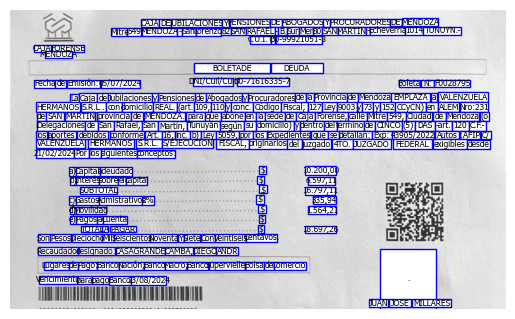

In [66]:
fig, ax = plt.subplots()

ax.imshow(image)

for word in words:
    x, y, w, h = xyxy_to_xywh(word["boundingPolygon"]["normalizedVertices"][1]["x"], word["boundingPolygon"]["normalizedVertices"][1]["y"],
                                word["boundingPolygon"]["normalizedVertices"][3]["x"], word["boundingPolygon"]["normalizedVertices"][3]["y"])
    
    cx, cy, w, h = xyxy_to_cxcywh(word["boundingPolygon"]["normalizedVertices"][1]["x"], word["boundingPolygon"]["normalizedVertices"][1]["y"],
                                word["boundingPolygon"]["normalizedVertices"][3]["x"], word["boundingPolygon"]["normalizedVertices"][3]["y"])
    
    rect = patches.Rectangle((x * width, y * height), w * width, h * height, linewidth=1, edgecolor='blue', facecolor='white')

    ax.text(cx * width, cy * height, word["text"], horizontalalignment='center',
    verticalalignment='center', fontsize=6, color='black', fontfamily="Tahoma")
    # Add the patch to the Axes
    ax.add_patch(rect)

ax.set_axis_off()
plt.savefig('output.png')
plt.show()


In [67]:
pii_words = [pii_words.text for pii_words in pii.documents[0].entities]
pii_words

['MENDOZA Mitre',
 '05/07/2024',
 '21/02/2024',
 'CASAGRANDE CAMBA',
 'DIEGO ANDR',
 '23/08/2024',
 'JUAN JOSE MILLARES']

In [68]:
text_in_words

'CAJA DE JUBILACIONES Y PENSIONES DE ABOGADOS Y PROCURADORES DE MENDOZA Mitre 549 MENDOZA - San Lorenzo 82 SAN RAFAEL - B. Sur Mer 80 SAN MARTIN - Echeverría 1014 TUNUYN.- C.U.I.T : 30-99921051-8 CAJA FORENSE MENDOZA BOLETADE DEUDA Fecha de Emisión: 05/07/2024 DNI/Cuil/Cuit 30-71616335-7 Boleta N: F0028795 La Caja de Jubilaciones y Pensiones de Abogados y Procuradores de la Provincia de Mendoza EMPLAZA a VALENZUELA HERMANOS S.R.L.. con domicilio REAL. (art. 109, 110 y conc. Código Fiscal; 127 Ley 9003 y 73 y 152 CCyCN) en ALEM Nro:231 de SAN MARTIN provincia de MENDOZA. para que abone en la sede de Caja Forense, calle Mitre 549, Ciudad de Mendoza (o Delegaciones de San Rafael, San Martín, Tunuyán según su domicilio) y dentro del término de CINCO (5) DAS -art. 120 C.F.- los aportes debidos conforme Art. 16, inc. b) Ley 5059, por los Expedientes que se detallan: Exp: 43905/2022 Autos :AFIP C/ VALENZUELA HERMANOS S.R.L. S/EJECUCION FISCAL, originarios del juzgado 4TO. JUZGADO FEDERAL exig

In [69]:
filtered_pii_words = list(filter(lambda word: word["text"] in pii_words, words))
filtered_pii_words

[{'text': '05/07/2024',
  'confidence': 0.9778667,
  'boundingPolygon': {'normalizedVertices': [{'x': 0.18345588235294116,
     'y': 0.23353658536585367},
    {'x': 0.26176470588235295, 'y': 0.23353658536585367},
    {'x': 0.26176470588235295, 'y': 0.25914634146341464},
    {'x': 0.18345588235294116, 'y': 0.25914634146341464}]}},
 {'text': '21/02/2024',
  'confidence': 0.9861458,
  'boundingPolygon': {'normalizedVertices': [{'x': 0.05183823529411765,
     'y': 0.46402439024390246},
    {'x': 0.1287657008451574, 'y': 0.46469064107755337},
    {'x': 0.1285038443172679, 'y': 0.49456790831030867},
    {'x': 0.051477948357077204, 'y': 0.49390165747665776}]}},
 {'text': '23/08/2024',
  'confidence': 0.9844101,
  'boundingPolygon': {'normalizedVertices': [{'x': 0.24375,
     'y': 0.8889582192025534},
    {'x': 0.31470588235294117, 'y': 0.8896306479849466},
    {'x': 0.31470588235294117, 'y': 0.9188989406678735},
    {'x': 0.24375, 'y': 0.9182265118854802}]}}]

In [70]:
width, height = image.width, image.height

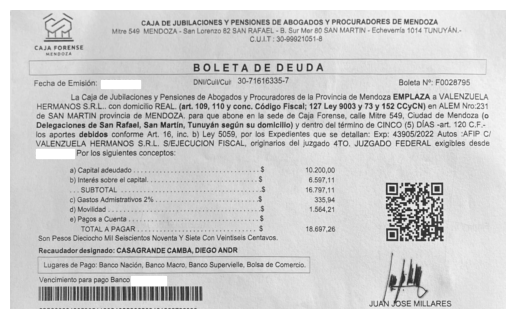

In [71]:
fig, ax = plt.subplots()

ax.imshow(image)

for word in filtered_pii_words:
    x, y, w, h = xyxy_to_xywh(word["boundingPolygon"]["normalizedVertices"][1]["x"], word["boundingPolygon"]["normalizedVertices"][1]["y"],
                                word["boundingPolygon"]["normalizedVertices"][3]["x"], word["boundingPolygon"]["normalizedVertices"][3]["y"])
    
    cx, cy, w, h = xyxy_to_cxcywh(word["boundingPolygon"]["normalizedVertices"][1]["x"], word["boundingPolygon"]["normalizedVertices"][1]["y"],
                                word["boundingPolygon"]["normalizedVertices"][3]["x"], word["boundingPolygon"]["normalizedVertices"][3]["y"])
    
    rect = patches.Rectangle((x * width, y * height), w * width, h * height, linewidth=1, edgecolor='white', facecolor='white')

    ax.add_patch(rect)

ax.set_axis_off()

# Save image to vytes
buffer = BytesIO()
plt.box(False)
plt.savefig(buffer, format="png", bbox_inches='tight', pad_inches=0)

In [72]:
from PIL import Image

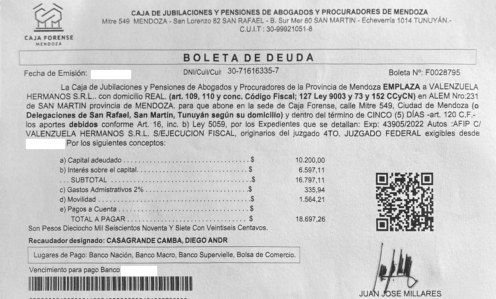

In [73]:
Image.open(buffer)

In [74]:
def filter_pii_words(words, pii_words):
    filtered_pii_words = []
    for word in words:
        if validate_cuit(word["text"]):
            filtered_pii_words.append(word)
        if (word["text"] in pii_words):
            filtered_pii_words.append(word)
            pii_words.remove(word["text"])
    return filtered_pii_words

def validate_cuit(cuit):
    return re.match(r'^\d{2}-\d{8}-\d$', cuit)

def filter_pii_words_given_entities(words, entities):
    filtered_pii_words = []
    for word in words:
        if word["text"] in entities:
            filtered_pii_words.append(word)
    return filtered_pii_words

In [75]:
def filter_entities(entities):
    ALLOWED_ENTITIES = ["PERSON", "LOCATION", "ORGANIZATION"]
    filtered_entities = []
    for entity in entities:
        if (entity.type in ALLOWED_ENTITIES) and entity.score > 0.6:
            filtered_entities.append(entity.text)
    return filtered_entities

In [77]:
filtered_entities = filter_entities(entities)
filtered_entities

['CAJA DE JUBILACIONES Y PENSIONES DE ABOGADOS Y PROCURADORES DE MENDOZA',
 'Mitre',
 'MENDOZA - San Lorenzo',
 'SAN RAFAEL',
 'B. Sur Mer',
 'SAN MARTIN',
 'Echeverría',
 'C.U.I.T',
 'CAJA FORENSE MENDOZA',
 'DNI/Cuil/Cuit',
 'Caja de Jubilaciones y Pensiones de Abogados y Procuradores de la Provincia',
 'Mendoza',
 'VALENZUELA',
 'domicilio REAL',
 'Código',
 'SAN MARTIN',
 'provincia de MENDOZA',
 'Caja Forense',
 'calle Mitre 549',
 'Mendoza',
 'San Rafael',
 'San Martín',
 'Tunuyán',
 'domicilio',
 'AFIP',
 'VALENZUELA',
 'juzgado',
 'JUZGADO FEDERAL',
 'CASAGRANDE',
 'CAMBA',
 'DIEGO',
 'Banco Nación',
 'Banco Macro',
 'Banco Supervielle',
 'Bolsa de Comercio',
 'JUAN JOSE MILLARES']

In [80]:
filtered_pii_words = list(filter(lambda word: word["text"] in filtered_entities, words))
filtered_pii_words

[{'text': 'Mitre',
  'confidence': 0.95136786,
  'boundingPolygon': {'normalizedVertices': [{'x': 0.20441176470588235,
     'y': 0.060365853658536583},
    {'x': 0.23621323529411764, 'y': 0.06014585727598609},
    {'x': 0.23621323529411764, 'y': 0.08636536947110804},
    {'x': 0.20441176470588235, 'y': 0.08658536585365853}]}},
 {'text': 'Echeverría',
  'confidence': 0.95136786,
  'boundingPolygon': {'normalizedVertices': [{'x': 0.7261029411764706,
     'y': 0.05675691278969369},
    {'x': 0.7970588235294118, 'y': 0.05626605429300448},
    {'x': 0.7970588235294118, 'y': 0.08248557114019626},
    {'x': 0.7261029411764706, 'y': 0.08297642033274581}]}},
 {'text': 'C.U.I.T',
  'confidence': 0.9799315,
  'boundingPolygon': {'normalizedVertices': [{'x': 0.48308823529411765,
     'y': 0.08597560975609755},
    {'x': 0.5266544117647058, 'y': 0.08597560975609755},
    {'x': 0.5266544117647058, 'y': 0.11219512195121951},
    {'x': 0.48308823529411765, 'y': 0.11219512195121951}]}},
 {'text': 'DNI/

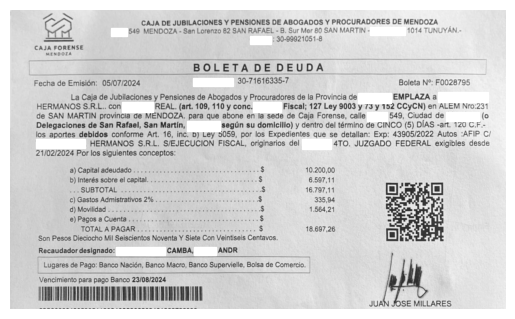

In [81]:
fig, ax = plt.subplots()

ax.imshow(image)

for word in filtered_pii_words:
    x, y, w, h = xyxy_to_xywh(word["boundingPolygon"]["normalizedVertices"][1]["x"], word["boundingPolygon"]["normalizedVertices"][1]["y"],
                                word["boundingPolygon"]["normalizedVertices"][3]["x"], word["boundingPolygon"]["normalizedVertices"][3]["y"])
    
    cx, cy, w, h = xyxy_to_cxcywh(word["boundingPolygon"]["normalizedVertices"][1]["x"], word["boundingPolygon"]["normalizedVertices"][1]["y"],
                                word["boundingPolygon"]["normalizedVertices"][3]["x"], word["boundingPolygon"]["normalizedVertices"][3]["y"])
    
    rect = patches.Rectangle((x * width, y * height), w * width, h * height, linewidth=1, edgecolor='white', facecolor='white')

    ax.add_patch(rect)

ax.set_axis_off()

# Save image to vytes
buffer = BytesIO()
plt.box(False)
plt.savefig(buffer, format="png", bbox_inches='tight', pad_inches=0)